In [51]:
# import packages
import rioxarray as rx
import matplotlib.pyplot as plt
import cmocean
from skimage import measure
from mpl_toolkits.axes_grid1 import make_axes_locatable
import datetime
import matplotlib.dates as mdates

In [2]:
# define data and script directory (replace with your data directory file path) and file path
data_dir = '/Volumes/Extreme SSD/data'
script_dir = '/Users/Wilson/Documents/0-code/scripts'
# point to ATL15 data granuale
# https://doi.org/10.5067/ATLAS/ATL15.001
file = data_dir + '/altimetry/ICESat-2/ATL15.001-Ant/ATL15_AA_0311_01km_001_01.nc'

In [3]:
# open ATL15 file with rioxarray
ATL15_dh=rx.open_rasterio(file, group='delta_h', masked=True)
ATL15_dh

<xarray.Dataset>
Dimensions:              (y: 4521, x: 5521, band: 1, time: 12)
Coordinates:
  * y                    (y) float64 2.32e+06 2.319e+06 ... -2.199e+06 -2.2e+06
  * x                    (x) float64 -2.72e+06 -2.719e+06 ... 2.799e+06 2.8e+06
  * band                 (band) int64 1
    Polar_Stereographic  int64 0
  * time                 (time) float64 273.9 365.2 ... 1.187e+03 1.278e+03
Data variables:
    cell_area            (band, y, x) float32 ...
    delta_h              (time, y, x) float32 ...
    delta_h_sigma        (time, y, x) float32 ...
    ice_mask             (band, y, x) float32 ...
    data_count           (time, y, x) float32 ...
    misfit_rms           (time, y, x) float32 ...
    misfit_scaled_rms    (time, y, x) float32 ...
Attributes: (12/118)
    description:                        This data set (ATL15) contains season...
    identifier:                         atl15_qa_util
    pulse_rate:                         10000 pps
    type:                               Spacecraft
    wavelength:                         532 nm
    Description:                        Describe the group
    ...                                 ...
    summary:                            The purpose of ATL15 is to provide an...
    time_coverage_duration:             70616089.15128851
    time_coverage_end:                  2021-06-23T16:19:43.177120Z
    time_coverage_start:                2019-03-29T08:44:54.025831Z
    time_type:                          CCSDS UTC-A
    vertical_datum:                     WGS84

In [4]:
# import subglacial lake outlines 
outlines = open(script_dir + '/SiegfriedFricker2018_outlines.py')
read_file = outlines.read()
exec(read_file)

outlines = open(script_dir + '/Smith2009_outlines.py')
read_file = outlines.read()
exec(read_file)

# drop outlines from SiegfiedFricker2018_outlines that are duplicative of Smith2009_outlines
SiegfriedFricker2018_outlines.drop(SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['cite'].str.contains('Smith and others, 2009')].index, inplace=True)

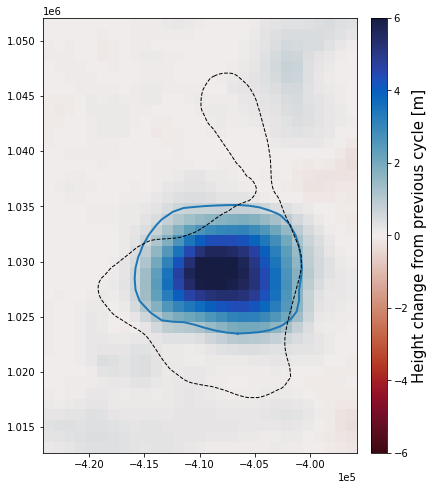

In [24]:
# def IS2_variable_outline_dhdvdt(lakename): 
#     '''
#     Create avg. lake dh/dt and dv/dt using time-variable outliens of all lakes in Siegfried and Fricker, 2018. 
#     '''
lakename = 'Slessor_23'
# isolate individual lake using gpd buffer
#lake_gpd = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename]
lake_gpd = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename]
lake_buffer = lake_gpd.buffer(5000)
# define lake bounding box
x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
# subset ATL15 data set to region of interest
mask_x = (ATL15_dh.x >= x_min) & (ATL15_dh.x <= x_max)
mask_y = (ATL15_dh.y >= y_min) & (ATL15_dh.y <= y_max)
ATL15_dh_sub = ATL15_dh.where(mask_x & mask_y, drop=True)
# find appropriate color map scale
height_anom_pos = []
height_anom_neg = []
for cyc in range(len(ATL15_dh_sub.time)-1):
    pos = np.nanmax(ATL15_dh_sub.delta_h[cyc+1,:,:]-ATL15_dh_sub.delta_h[cyc,:,:])
    neg = np.nanmin(ATL15_dh_sub.delta_h[cyc+1,:,:]-ATL15_dh_sub.delta_h[cyc,:,:])
    height_anom_pos += [pos]
    height_anom_neg += [neg]
max_height_anom_pos = max(height_anom_pos)
max_height_anom_neg = min(height_anom_neg)
v = np.round(max(max_height_anom_pos,abs(max_height_anom_neg)))
# for discrete colorbar using levels kwarg
# n=int(2*v) # double for pos/neg
# levels = np.linspace(-v, v, n+1) # add 1 to n to account for 0
# for idx in range(len(ATL15_dh_sub.delta_h)): 
idx = 3 # hard coded to debug
# plot figure
fig, ax = plt.subplots(figsize=(8,8))
dhdt = ATL15_dh_sub.delta_h[idx+1,:,:]-ATL15_dh_sub.delta_h[idx,:,:]
img = ax.imshow(dhdt, extent=[x_min, x_max, y_min, y_max], 
    origin='upper', cmap=cmocean.cm.balance_r, vmin=-v, vmax=v)
contours = measure.find_contours(dhdt.values, 1)
# create mapping conversion factor to map array location to polar stereographic x,y
x_conv = (x_max-x_min)/dhdt.shape[1]
y_conv = (y_max-y_min)/dhdt.shape[0]
for contour in contours:
    ax.plot(contour[:, 1]*x_conv+x_min, y_max-contour[:, 0]*y_conv, linewidth=2)
SiegfriedFricker2018_outlines.boundary.plot(ax=ax, color='k', linestyle='--', linewidth=1)
# cntr = ax.contour(ATL15_dh_sub.x, ATL15_dh_sub.y, ATL15_dh_sub.delta_h[idx+1,:,:]-ATL15_dh_sub.delta_h[idx,:,:], 
#         levels = [-0.75, 0.75], 
#         alpha = 0.75,
#         origin='lower', 
#         extent=[x_min,x_max,y_min,y_max],
#         colors='k',
#         #colors=[cmap(norm(t[tstep]))], 
#         linewidths=2) 
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
ax.ticklabel_format(axis='both',scilimits=(0,0))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(img, cax=cax).set_label('Height change from previous cycle [m]', size=15)

# clip ATL15 data to just show (first set crs)
# ATL15_dh_sub.rio.write_crs(3031, inplace=True)
# ATL15_dh_sub_clipped = ATL15_dh_sub.rio.clip(lake_gpd.geometry.values, lake_gpd.crs, drop=False, invert=False) # CLIP TO TIME VARIABLE OUTLINE


In [69]:
# def ATL15_var_outline_dhdvdt(lakename,thres): 
'''
Function to calculate the lake avg. dh/dt and dv/dt using time-variable outlines.
'''
lakename = 'Slessor_23' # hardcoding until func debugged
# isolate individual lake using gpd buffer
#lake_gpd = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename]
lake_gpd = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename]
lake_buffer = lake_gpd.buffer(5000)
# define lake bounding box
x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
# subset ATL15 data set to region of interest
mask_x = (ATL15_dh.x >= x_min) & (ATL15_dh.x <= x_max)
mask_y = (ATL15_dh.y >= y_min) & (ATL15_dh.y <= y_max)
ATL15_dh_sub = ATL15_dh.where(mask_x & mask_y, drop=True)
# creat empty lists to fill with data
contours = []
IS2_dates = []
IS2_lkavgdhdt = []
IS2_vols = []
thres = 1 # hard coding to debug func
for idx in range(len(ATL15_dh.delta_h)-1):
    dhdt = ATL15_dh_sub.delta_h[idx+1,:,:]-ATL15_dh_sub.delta_h[idx,:,:]
    cntrs_fill = measure.find_contours(dhdt.values, thres)
    contours += [cntrs_fill]
    cntrs_drain = measure.find_contours(dhdt.values, -thres)
    contours += [cntrs_drain]
    # create mapping conversion factor to map array location to polar stereographic x,y
    x_conv = (x_max-x_min)/ATL15_dh_sub.delta_h.shape[1]
    y_conv = (y_max-y_min)/ATL15_dh_sub.delta_h.shape[0]
    # create polygon from created contours converting from ndarray coords to polar stereographic x,y
    for contour in contours:
        p = Polygon(list(zip(contour[:, 1]*x_conv+x_min, y_max-contour[:, 0]*y_conv)))
    # clip ATL15 data to polygon outline (first set crs)
    ATL15_dh_sub.rio.write_crs(3031, inplace=True)
    ATL15_dh_sub_clipped = ATL15_dh_sub.rio.clip([p], invert=False) # drop=False, FIGURE OUT WHAT THIS KWARG DOES
    # calculate mid-cycle dates for plotting
    date_time_str = ATL15_dh_sub_clipped.attrs['rangeBeginningDateTime'][2:10]
    date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
    newdate = date_time_obj + datetime.timedelta(days=ATL15_dh_sub_clipped.time.values[idx])
    newdate1 = date_time_obj + datetime.timedelta(days=ATL15_dh_sub_clipped.time.values[idx+1])
    midcycdays = newdate1 - newdate
    midcycdate = newdate + midcycdays
    IS2_dates += [midcycdate]
    # calculate lake avg. dh/dt
    avg_lk_dhdt = np.ma.average(np.ma.MaskedArray(dhdt, mask=np.isnan(arr)))
    IS2_lkavgdhdt += [avg_lk_dhdt]
    # calculate dv/dt
    vol = avg_lk_dhdt*p.area
    IS2_vols += [vol]
# plot average lake height time series
fig, ax = plt.subplots()
ax.plot(IS2_dates, IS2_lkavgdhdt)
locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_title('{} average lake height time series'.format(lakename))
ax.set_xlabel('Year')
ax.set_ylabel('Avg. height change from previous cycle [m]')
# plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output/IS2-avglkdhdt-lineplots-varoutlines/IS2-avglkdhdt-{}.png'.format(lakename), dpi=300, bbox_inches = "tight")
# plt.close()
# plot volume change time series
fig, ax = plt.subplots()
ax.plot(IS2_dates, np.divide(IS2_vols, 1e+9))
locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_title('{} volume change time series'.format(lakename))
ax.set_xlabel('Year')
ax.set_ylabel('Volume change [km$^3$]')
# plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output/IS2-dvdt-lineplots-varoutlines/IS2-dvdt-{}.png'.format(lakename), dpi=300, bbox_inches = "tight")
# plt.close()


TypeError: list indices must be integers or slices, not tuple

In [77]:
len(contours[1])

0

In [74]:
if len(contours) == 0:
    print('the list is empty')
else:
    print('the list has contents')

the list has contents


In [49]:
vol.values

AttributeError: 'numpy.float64' object has no attribute 'values'